# __[ LG Energy Solution ] <br><br>Anomaly Detection Part2: Recurrunt Auto-Encoder__

# <br>__1. Data: NASA Bearing Dataset__

In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/hj-choi-95/Anomaly_Detection_Part2.git

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Step1. 데이터 불러오기

In [2]:
# 데이터 불러오기
data = pd.read_csv('/content/Anomaly_Detection_Part2/data/nasa_bearing_dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065,0,train
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540,0,train
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442,0,train
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081,0,train
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118,0,train


### Step2. 데이터 Split

In [3]:
X_train = data[data['data_type'] == 'train'].iloc[:, :4]
y_train = data[data['data_type'] == 'train'].iloc[:, -2].values

X_test = data[data['data_type'] == 'test'].iloc[:, :4]
y_test = data[data['data_type'] == 'test'].iloc[:, -2].values

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (492, 4)
Test data shape: (492, 4)


### Step3. 데이터 정규화

In [4]:
# train 데이터를 기반으로 train/test 데이터에 대하여 min-max scaling 적용 
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

---

# __<br>2. Recurrent Auto-Encoder__

### Recurrent Auto-Encoder
>입력과 출력이 동일한 인공신경망 구조 <br>
>정상 데이터에 대한 학습이 충분히 되어 있을 경우 정상 데이터는 자기 자신을 잘 복원할 수 있지만, 이상치 제이터는 학습 기회가 적어 상대적으로 잘 복원하지 못할 것을 가정

<img src="https://i.imgur.com/KpyS57D.jpg" width="700">

In [6]:
import random
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [7]:
# hyper-parameter 설정
seq_len = 5
input_size = 4
hidden_size = 2

num_epochs = 20
batch_size = 32
learning_rate = 0.001

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [8]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

### Step 1. DataLoader 만들기 (Custom dataset)

In [9]:
class RAE_CustomDataset(Dataset): 
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
        self.start_point = range(0, len(data) - seq_len)

    # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.start_point)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[self.start_point[idx]:self.start_point[idx] + self.seq_len]) # shape: (batch_size, seq_len, n_features)
        return x

In [10]:
rae_train_dataset = RAE_CustomDataset(X_train, seq_len)
rae_train_loader = DataLoader(rae_train_dataset, batch_size=batch_size, shuffle=True)

rae_test_dataset = RAE_CustomDataset(X_test, seq_len)
rae_test_loader = DataLoader(rae_test_dataset, batch_size=batch_size, shuffle=False)

### Step 2. 모델 구축

In [11]:
class RecurrentAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len):
        super(RecurrentAutoEncoder, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size = hidden_size,
            hidden_size = 2 * hidden_size,
            num_layers = 1,
            batch_first = True
        )
        self.fc = nn.Linear(2 * hidden_size, input_size)
                
    def forward(self, x):
        enc_x, (enc_hidden_state, enc_cell_state) = self.encoder(x)
        enc_last_hidden = enc_hidden_state[-1, :, :]
        
        enc_last_hidden = enc_last_hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
        dec_x, (dec_hidden_state, dec_cell_state) = self.decoder(enc_last_hidden)
        dec_x = dec_x.reshape((x.size(0), self.seq_len, -1))
        
        out = self.fc(dec_x)
        out = F.sigmoid(out)
        return out

In [12]:
rae_model = RecurrentAutoEncoder(input_size, hidden_size, seq_len)

### Step 3. Train 데이터로 모델 학습

In [13]:
# model 학습
def train_model(data_loader, model, criterion, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(num_epochs):
        for i, x in enumerate(data_loader):
            x = x.to(device)
            
            # Forward pass
            outputs = model(x)
            loss = criterion(outputs, x)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 5 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, len(data_loader), loss.item()))
    
    return model

In [14]:
rae_train_criterion = nn.MSELoss()
rae_model = train_model(rae_train_loader, rae_model, rae_train_criterion, num_epochs, learning_rate, device)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20], Step [5/16], Loss: 0.0395
Epoch [1/20], Step [10/16], Loss: 0.0378
Epoch [1/20], Step [15/16], Loss: 0.0359
Epoch [2/20], Step [5/16], Loss: 0.0405
Epoch [2/20], Step [10/16], Loss: 0.0330
Epoch [2/20], Step [15/16], Loss: 0.0371
Epoch [3/20], Step [5/16], Loss: 0.0373
Epoch [3/20], Step [10/16], Loss: 0.0414
Epoch [3/20], Step [15/16], Loss: 0.0384
Epoch [4/20], Step [5/16], Loss: 0.0370
Epoch [4/20], Step [10/16], Loss: 0.0375
Epoch [4/20], Step [15/16], Loss: 0.0393
Epoch [5/20], Step [5/16], Loss: 0.0357
Epoch [5/20], Step [10/16], Loss: 0.0332
Epoch [5/20], Step [15/16], Loss: 0.0366
Epoch [6/20], Step [5/16], Loss: 0.0362
Epoch [6/20], Step [10/16], Loss: 0.0309
Epoch [6/20], Step [15/16], Loss: 0.0319
Epoch [7/20], Step [5/16], Loss: 0.0355
Epoch [7/20], Step [10/16], Loss: 0.0351
Epoch [7/20], Step [15/16], Loss: 0.0296
Epoch [8/20], Step [5/16], Loss: 0.0306
Epoch [8/20], Step [10/16], Loss: 0.0313
Epoch [8/20], Step [15/16], Loss: 0.0309
Epoch [9/20], Step [5/16

### Step 4. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출 (Inference)

In [15]:
# model inference
def inference_model(data_loader, model, criterion, device):
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        infer_loss = []
        for i, x in enumerate(data_loader):
            x = x.to(device)
            
            # Forward pass
            output = model(x)
            loss = criterion(output, x)
            loss = loss.mean(axis=1).mean(axis=1)

            infer_loss += list(loss.data.numpy())
    infer_loss = np.array(infer_loss).flatten()
    return infer_loss

In [16]:
# train 데이터에 대한 최종 결과 도출
rae_infer_criterion = nn.L1Loss(reduction='none')
rae_train_loss = inference_model(rae_train_loader, rae_model, rae_infer_criterion, device)
rae_test_loss = inference_model(rae_test_loader, rae_model, rae_infer_criterion, device)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

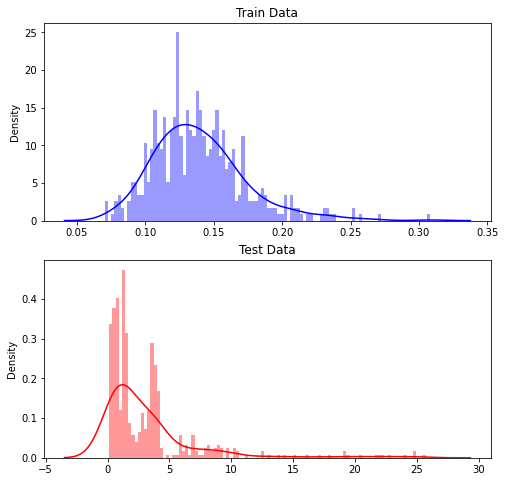

In [17]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(rae_train_loss, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(rae_test_loss, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 5. Threshold 탐색

In [18]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [19]:
# best threshold 탐색
rae_best_threshold = search_best_threshold(rae_test_loss, y_test[seq_len:], num_step=1000)

Best threshold:  1.2825
Best F1 Score: 0.9834


### Step 6. Best threshold를 기반으로 이상치 탐지 모형 평가

In [20]:
train_dates = data[data['data_type'] == 'train'].index[seq_len:]
test_dates = data[data['data_type'] == 'test'].index[seq_len:]

In [21]:
rae_scores = pd.DataFrame(index=list(train_dates) + list(test_dates))
rae_scores['score'] = list(np.hstack([rae_train_loss, rae_test_loss]))
rae_scores['anomaly'] = rae_best_threshold < rae_scores['score']
rae_scores.head()

,score,anomaly
2004-02-12 11:22:39,0.107840,False
2004-02-12 11:32:39,0.099066,False
2004-02-12 11:42:39,0.162821,False
2004-02-12 11:52:39,0.115832,False
2004-02-12 12:02:39,0.152953,False


In [22]:
# anomaly score plot 도출
def draw_plot(scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(data.index[int(len(data) * 0.5)], c='orange', ls='--')
    
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

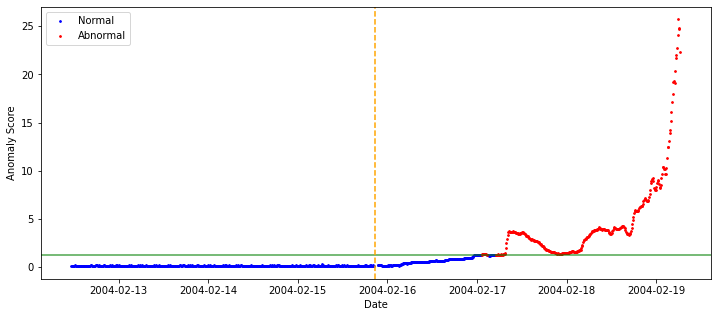

In [23]:
# 전체 기간의 데이터 분포 확인
draw_plot(rae_scores, rae_best_threshold)

In [24]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)
    
    return frr, far, f1

In [25]:
# F1 Score: 0.9834
frr, far, f1 = calculate_metric(y_test[seq_len:], rae_scores['anomaly'][test_dates[0]:])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.0524  |  FAR: 0.0  |  F1 Score: 0.9834


---